Расчет коэффициента размножения нейтронов в гомогенном реакторе с использованием формулы четырех сомножителей

In [1]:
import pandas as pd
import numpy as np
from typing import Dict
from itertools import product
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
!pip3 install mendeleev
import mendeleev

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 kB 15.3 MB/s eta 0:00:00


## Данные
В качестве исходных данных в работе используются
- обогащение урана $x$ - отношение доли U-235 к доле U-238 в урановом топливе, $x = \dfrac{N_{235}}{N_{238}}$  
- $\sigma_f, \sigma _c, \sigma _s$ - микросечения деления (f), поглощения (c), рассеяния (s), $10^{-24} см^2 = 1\ б$  
- $\rho$ - плотность вещества, $[г/см^3]$  
- $M$ - молярная масса, $[г/моль]$
- $\xi$ - средний логарифмический декремент энергии
- $\epsilon$ - объемная доля компоненты гомогенного реактора  


Обогащение: $x \in [0.00714, 0.01, 0.02, 0.03, 0.04, 0.05]$

Типы компонент:  
- топливо [T] ($U, UO_2$)  
- теплоноситель [ТН] ($H_2O, D_2O$)  
- замедлитель [З] ($H_2O, D_2O, C$)  
- конструкционные материалы [К] ($Zr, Fe$)  
В качестве значений молярной массы  используйте молярные массы **наиболее распространенных в природе** изотопов.  
Необходимо выяснить распространенность и извлечь значения из библиотеки `mendeleev`, явным образом отразить поиск и выбор в тексте работы.

In [2]:
density = {'U': 18.9, 'UO2': 10.96}
fuel_M = {'U' : 238, 'UO2' : 270}
fuel_params = pd.DataFrame(data={}, index = ['U_235', 'U_238'])

class PARAMS:
  def setAttr(name, attr):
    setattr(PARAMS, name, attr)

Fuel = pd.DataFrame(data = [density, fuel_M], index=["density", "M"])
PARAMS.setAttr("Fuel", Fuel)
Fuel

,U,UO2
density,18.9,10.96
M,238.0,270.00


Значения микросечений деления, рассеяния и захвата по данным [РОССФОНД-2010](https://www-nds.iaea.org/exfor/endf.htm) при тепловых энергиях (0.025 эВ).



In [3]:
import pandas as pd

def mol_mass(element_symbol):
    if element_symbol != 'D':
      el = mendeleev.element(element_symbol)
      isotopes = el.isotopes
      most_abundant = max(isotopes, key=lambda iso: 0 if iso.abundance is None else iso.abundance)
      return most_abundant.mass
    else:
      for iso in mendeleev.element('H').isotopes:
        if iso.mass_number == 2:
          return iso.mass



In [4]:
params = pd.DataFrame(data={
    'density':  [1.00, 1.10, 1.60, 6.51, 7.87],  # плотность вещества, г/см³
    's_c':  [0.66, 0.001, 0.004, 0.185, 2.62], # микросечение захвата
    's_s':  [63, 13.6, 4.8, 8, 11.4], # микросечение рассеяни
    'decr': [0.948, 0.57, 0.158, 0.022, 0.035],  # лог. декремент энергии
    'type': ['Z/TH', 'Z/TH', 'Z', 'K', 'K']  # Z/ТН - замедлитель/теплоноситель (ввэр), Z-замедлитель(рбмк), K - материал
}, index=['H2O', 'D2O', 'C', 'Zr', 'Fe'])
params['M'] = None
for index, row in params.iterrows():
    if index == 'H2O':
        params.loc[index, 'M'] = 2 * mol_mass('H') + mol_mass('O')
    elif index == 'D2O':
        params.loc[index, 'M'] = 2 * mol_mass('D') + mol_mass('O')
    else:
        element_symbol = index
        params.loc[index, 'M'] = mol_mass(element_symbol)

fuel_params = pd.DataFrame(data={
     's_f' : [585.7, 1.7e-5],   # микросечение деления
     's_s' : [15.12, 9.3],
     's_c' : [98.83, 2.7]
}, index=['U_235', 'U_238'])

print("params:")
print(params)

print("\nfuel_params:")
print(fuel_params)

params:
     density    s_c   s_s   decr  type          M
H2O     1.00  0.660  63.0  0.948  Z/TH  18.010565
D2O     1.10  0.001  13.6  0.570  Z/TH  20.023118
C       1.60  0.004   4.8  0.158     Z       12.0
Zr      6.51  0.185   8.0  0.022     K  89.904699
Fe      7.87  2.620  11.4  0.035     K  55.934936

fuel_params:
              s_f    s_s    s_c
U_235  585.700000  15.12  98.83
U_238    0.000017   9.30   2.70


В качестве долей компонент реактора в работе используются:
1. РБМК: Т - 0.0316, ТН - 0.038, К - 0.903, З - 0.0272.
2. ВВЭР: Т - 0.002, ТН - 0.9974, К - 0.002, З - 0.0.



In [5]:
vver = {'T': 0.002,'TH': 0.9974,'K': 0.002,'Z': 0}
rbmk = {'T': 0.0316,'TH': 0.038,'K': 0.903,'Z': 0.0272} #T - топливо
share = pd.DataFrame(data = {'RBMK' : rbmk.values(),'VVER' : vver.values()},
                     index = ['T', 'TH', 'K', 'Z'])

share

,RBMK,VVER
T,0.0316,0.0020
TH,0.0380,0.9974
K,0.9030,0.0020
Z,0.0272,0.0000


In [6]:
PARAMS.setAttr("basicParams", params)
PARAMS.setAttr("fuelParams", fuel_params)
na = 6.02e23
PARAMS.Fuel.loc['N', :] = PARAMS.Fuel.loc['density', :] * na / PARAMS.Fuel.loc['M', :] * 10**(-24)
PARAMS.basicParams['N'] = PARAMS.basicParams['density'] * na / PARAMS.basicParams['M'] * 10**(-24)
PARAMS.Fuel = PARAMS.Fuel.T
PARAMS.setAttr("reactors", share)


## Формулы расчета  
Формула четырех сомножителей: $k_{\infty} = \dfrac{n'}{n} =\dfrac{n\ \mu \phi \theta \eta}{n} = \mu \phi \theta \eta$, где  
$\mu$ - коэффициент размножения на быстрых нейтронах;  
$\phi$ - вероятность избежать резонансного захвата;  
$\theta$ - коэффициент использования тепловых нейтронов (доля тепловых нейтронов, захваченных в топливе);  
$\eta$ - число эффективных нейтронов деления (быстрых нейтронов) на один тепловой нейтрон, захваченный в топливе.

1. приведите формулу расчета объемной концентрации $N$ c использованием плотности вещества $\rho$, молярной массы $M$.  
     
       
2. распишите формулы для сомножителей, используя только обогащение урана $x$, микросечения $\sigma$, эффективный интеграл $I_{эф}$, объемные концентрации $N$, средний логарифмический декремент энергии $\xi$, объемные доли компонент $\epsilon$ и индексы, соответствующие типам компонент (Т, ТН, К, З)
    
a (absorbtion) - поглощение,\
f (fission) - деление,\
с (capture) - захват \
поглощение(a) = деление (f) + захват (c) \
Компоненты среды реактора: топливо (Т), замедлитель (З), теплоноситель (ТН),
конструкционные материалы (К)

$N = \frac{\rho N_A}{M}$

$\mu = 1$

$\phi = \exp \left( - \frac{N_{8} \cdot I_{aэф}}{\xi_{3} \cdot N_3\sigma_{s3}} \right)$  

$N_{U} = x \cdot N_{5} + (1 - x) \cdot N_{8}$ \
$\theta = \frac{\Sigma_{aT}}{\Sigma_{aT} + \Sigma_{a3} + \Sigma_{aTH} + \Sigma_{aK}}$

$\Sigma_{a} = N \cdot \sigma_{a} \epsilon_{i}$

$\eta = \frac{\nu_f\sigma_{f5}}{\sigma_{f5} + \sigma_{c5} + \frac{  \sigma_{c8} }{x}}$

$I_{a e\phi} = 3.8 \cdot \left( \frac{\Sigma_s U_{238} + \Sigma_s}{N_{U_{238}} \cdot \varepsilon_T} \right)^{0.42}
= 3.8 \cdot \left( \sigma_s U_{238} + \frac{\sigma_3 \cdot N_3 \cdot \varepsilon_3}{N_{U_{238}} \cdot \varepsilon_T} \right)^{0.42}$

$\sigma_{c5} = \text{сечение поглощения } U-235$

$\sigma_{c8} = \text{сечение поглощения } U-238$




Расчет коэффициента размножения нейтронов на основе полученных формул в форме класса.  


In [7]:
class HomoReactor:
    'Ядерный реактор на тепловых нейтронах с бесконечной гомогенной активной зоной'
    s_f_235 =  585.7 # микросечение деления U-235
    s_c_235 =  98.83 # микросечение захвата U-235
    s_s_235 =  15.12 # микросечение рассеяния U-235
    s_c_238 =  2.7 # микросечение захвата U-238
    s_s_238 =  9.3 # микросечение рассеяния U-238
    nu_f =     2.42 # число нейтронов деления
    mu =       1 # коэффициент размножения на быстрых нейтронах в гомогенной среде
    AVOGADRO = 6.02e23

    fracts = None  # Доля вещества (глобальная переменная класса)

    @classmethod
    def chooseReactor(cls, fracts):
        cls.fracts = fracts

    def __init__(self,
                 components: Dict[str, str],
                 t_props: pd.Series,
                 other_props: pd.DataFrame):
        '''
        Аргументы:
        - components (Dict[str, str]): ключ - тип компоненты (Т, ТН, К, З), значение - выбранное вещество
        - t_props (pd.Series):          часть params, содержащая свойства (eps, N, x) выбранного топлива
        - other_props (pd.DataFrame):   свойства ТН, К, З для выбранной тройки веществ и никаких других
        '''
        self.x = t_props['x'] # обогащение урана
        self.t_eps = t_props['eps'] # относительный объем топлива в среде
        self.t_N = t_props['N'] # ядерная плотность топлива

        self.tn_props = other_props.loc[components['TH']]
        self.k_props = other_props.loc[components['K']]
        self.z_props = other_props.loc[components['Z']]

    def set_x(self, x):
        'Установить обогащение топлива'
        self.x = x

    def phi_calc(self):
        'Расчет вероятности избежать резонансного захвата'
        self.xi = self.z_props['decr'] if self.z_props is not None else self.tn_props['decr']
        self.S_sz = (
            self.z_props['s_s'] * self.z_props['N'] * self.z_props['eps']
            if self.z_props is not None else
            self.tn_props['s_s'] * self.tn_props['N'] * self.tn_props['eps']
        )
        self.N_8 = self.t_eps * self.t_N * (1 / (1 + self.x))
        self.I_a_eff = 3.8 * ((HomoReactor.s_s_238 + self.S_sz / self.N_8) ** 0.42)
        self.arg = -self.N_8 * self.I_a_eff / (self.xi * self.S_sz)
        self.phi = np.exp(self.arg)
        return self.phi, self.I_a_eff

    def theta_calc(self):
        'Расчет коэфф-та использования тепловых нейтронов'
        self.a = self.t_N * (HomoReactor.s_c_235 + HomoReactor.s_f_235) * self.t_eps
        self.b = (
            self.t_N * (HomoReactor.s_f_235 + HomoReactor.s_c_235) * self.t_eps +
            self.tn_props['N'] * self.tn_props['s_c'] * self.tn_props['eps'] +
            (self.z_props['N'] * self.z_props['s_c'] * self.z_props['eps'] if self.z_props is not None else 0) +
            self.k_props['N'] * self.k_props['s_c'] * self.k_props['eps']
        )
        return self.a / self.b

    def eta_calc(self):
        'Расчет эффективного числа нейтронов деления'
        self.eta = HomoReactor.nu_f * HomoReactor.s_f_235 / (
            HomoReactor.s_f_235 + HomoReactor.s_c_235 + HomoReactor.s_c_238 / self.x
        )
        return self.eta

    def k_calc(self):
        'Расчет коэффициента размножения'
        self.phi_value = self.phi_calc()[0]
        self.theta_value = self.theta_calc()
        self.eta_value = self.eta_calc()
        return HomoReactor.mu * self.phi_value * self.theta_value * self.eta_value

def getOtherProps(comp, reactor_type): #comp = {'T', 'TH' , 'K' , 'Z' },
  pass
  if (reactor_type == "RBMK"):
    other_props = pd.DataFrame(data={}, index=[comp['TH'], comp['K'], comp['Z']])
    other_props.insert(0, 'eps', [PARAMS.reactors.loc['TH',reactor_type], PARAMS.reactors.loc['K', reactor_type], PARAMS.reactors.loc['Z', reactor_type]])
  elif (reactor_type == "VVER"):
    other_props = pd.DataFrame(data={}, index=[comp['TH'], comp['K']])
    other_props.insert(0, 'eps', [PARAMS.reactors.loc['TH',reactor_type], PARAMS.reactors.loc['K', reactor_type]])
  else:
    other_props = pd.DataFrame(data={}, index=['Zr', 'Fe', comp['Z']])
    other_props.insert(0, 'eps', [PARAMS.reactors.loc['TH',reactor_type], PARAMS.reactors.loc['K', reactor_type], PARAMS.reactors.loc['Z', reactor_type]])
  other_props[['density', 's_c', 's_s', 'decr', 'M', 'N']] = PARAMS.basicParams[['density', 's_c', 's_s', 'decr', 'M', 'N']]
  return other_props


## Подготовка к расчетам

### 1. Обогащение урана

In [8]:
from mendeleev import element

# Получение изотопного состава природного урана
uranium = element('U')
isotopes = uranium.isotopes

# Поиск долей изотопов U-235 и U-238
u235_abundance = next(iso.abundance for iso in isotopes if iso.mass_number == 235) / 100
u238_abundance = next(iso.abundance for iso in isotopes if iso.mass_number == 238) / 100
# Рассчёт обогащения
x_natural = u235_abundance / (u235_abundance + u238_abundance)
x_vals = [x_natural, *[i*0.01 for i in range(1, 6)]] # обогащение урана, используемое в работе
x_vals

[0.007204389037007999, 0.01, 0.02, 0.03, 0.04, 0.05]

### 2. Комбинации веществ в реакторе



In [9]:
import itertools
fuels = ['U', 'UO2']
coolants = ['H2O', 'D2O']
moderators = ['H2O', 'D2O', 'C']
structural_materials = ['Zr', 'Fe']

combinations = list(itertools.product(fuels, coolants, moderators, structural_materials))

print('комбинации:')
for k in combinations:
    print(k)
print('Всего:', len(combinations), 'комбинации')

комбинации:
('U', 'H2O', 'H2O', 'Zr')
('U', 'H2O', 'H2O', 'Fe')
('U', 'H2O', 'D2O', 'Zr')
('U', 'H2O', 'D2O', 'Fe')
('U', 'H2O', 'C', 'Zr')
('U', 'H2O', 'C', 'Fe')
('U', 'D2O', 'H2O', 'Zr')
('U', 'D2O', 'H2O', 'Fe')
('U', 'D2O', 'D2O', 'Zr')
('U', 'D2O', 'D2O', 'Fe')
('U', 'D2O', 'C', 'Zr')
('U', 'D2O', 'C', 'Fe')
('UO2', 'H2O', 'H2O', 'Zr')
('UO2', 'H2O', 'H2O', 'Fe')
('UO2', 'H2O', 'D2O', 'Zr')
('UO2', 'H2O', 'D2O', 'Fe')
('UO2', 'H2O', 'C', 'Zr')
('UO2', 'H2O', 'C', 'Fe')
('UO2', 'D2O', 'H2O', 'Zr')
('UO2', 'D2O', 'H2O', 'Fe')
('UO2', 'D2O', 'D2O', 'Zr')
('UO2', 'D2O', 'D2O', 'Fe')
('UO2', 'D2O', 'C', 'Zr')
('UO2', 'D2O', 'C', 'Fe')
Всего: 24 комбинации


In [10]:

na = HomoReactor.AVOGADRO
x_vals = [x_natural, *[i*0.01 for i in range(1, 6)]] # обогащение урана, используемое в работе
fuel = 'U'
reactor_type = 'RBMK'
comp = {'T' : 'U', 'TH' : 'H2O', 'K' : 'Fe', 'Z' : 'C'}
reactor = HomoReactor(components=comp.copy(),
  t_props=pd.Series(data=[x_vals[0], PARAMS.reactors.loc['T', reactor_type], PARAMS.Fuel.loc[fuel, 'N']], index=['x', 'eps', 'N']),
  other_props= getOtherProps(comp, reactor_type))

## Исследование

### 1. Расчет коэффициента размножения
Коэффициент размножения нейтронов при каждой из комбинаций веществ в составе реактора с долями, соответствующими реакторам РБМК и ВВЭР.  

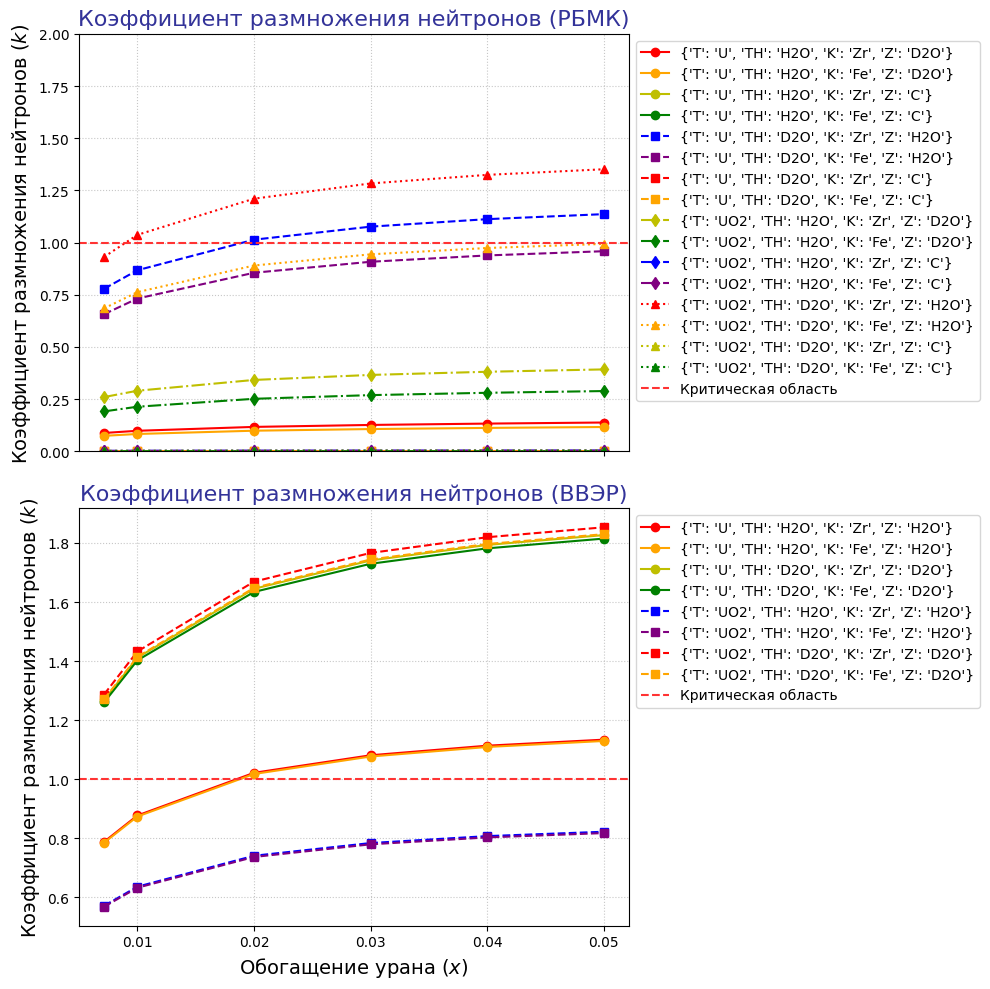

In [11]:

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 10))
ax1, ax2 = axes


# обогащение урана
x_values = [0.00714, 0.01, 0.02, 0.03, 0.04, 0.05]

# Цвета для линий и стили
colors = ['r', 'orange', 'y', 'g', 'blue', 'purple']
linestyles = ['-', '--', '-.', ':']
markers = ['o', 's', 'd', '^', 'v', 'x', '*']

# Переменные для отслеживания стиля
color_index = 0
style_index = 0

# Расчет коэффициента размножения нейтронов для РБМК
for var in combinations:
    reactorType = "RBMK"
    components = {'T': var[0], 'TH': var[1], 'K': var[3], 'Z': var[2]}

    if var[2] == var[1]:
        continue

    k_values = []
    reactor = HomoReactor(
        components=components.copy(),
        t_props=pd.Series(
            data=[x_values[0], PARAMS.reactors.loc['T', reactorType], PARAMS.Fuel.loc[components['T'], 'N']],
            index=['x', 'eps', 'N']
        ),
        other_props=getOtherProps(components, reactorType)
    )

    for _x_ in x_values:
        reactor.set_x(_x_)
        k_value = reactor.k_calc()
        k_values.append(k_value)

    ax1.plot(
        x_values, k_values,
        color=colors[color_index % len(colors)],
        linestyle=linestyles[style_index % len(linestyles)],
        marker=markers[style_index % len(markers)],
        label=f'{components}'
    )

    color_index += 1
    if color_index % len(linestyles) == 0:
        style_index += 1

# Сброс индексов стилей
color_index = 0
style_index = 0

# Расчет коэффициента размножения нейтронов для ВВЭР
for var in combinations:
    reactorType = "VVER"
    components = {'T': var[0], 'TH': var[1], 'K': var[3], 'Z': var[2]}

    if var[2] != var[1]:
        continue

    k_values = []
    reactor = HomoReactor(
        components=components.copy(),
        t_props=pd.Series(
            data=[x_values[0], PARAMS.reactors.loc['T', reactorType], PARAMS.Fuel.loc[components['T'], 'N']],
            index=['x', 'eps', 'N']
        ),
        other_props=getOtherProps(components, reactorType)
    )

    for _x_ in x_values:
        reactor.set_x(_x_)
        k_value = reactor.k_calc()
        k_values.append(k_value)

    ax2.plot(
        x_values, k_values,
        color=colors[color_index % len(colors)],
        linestyle=linestyles[style_index % len(linestyles)],
        marker=markers[style_index % len(markers)],
        label=f'{components}'
    )

    color_index += 1
    if color_index % len(linestyles) == 0:
        style_index += 1

for ax, title in zip([ax1, ax2], [
    'Коэффициент размножения нейтронов (РБМК)',
    'Коэффициент размножения нейтронов (ВВЭР)'
]):
    ax.axhline(y=1, color='#FF3333', linestyle='--', label='Критическая область')

    ax.set_ylabel('Коэффициент размножения нейтронов ($k$)', fontsize=14)
    ax.grid(True, linestyle=':', linewidth=0.8, alpha=0.7)
    ax.set_title(title, fontsize=16, color='#333399')

# Легенды
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

ax2.set_xlabel('Обогащение урана ($x$)', fontsize=14)
ax1.set_ylim(0, 2)

plt.tight_layout()
plt.show()


#Вывод:

При выполнении расчётов удалось выявить, что лишь некоторые комбинации параметров делают реактор "работоспособным".

Для реактора РБМК наиболее подходящими оказались сочетания:

    ('UO2', 'D2O', 'H2O', 'Fe')
    ('U', 'D2O', 'H2O', 'Fe').

Для реактора ВВЭР к оптимальным близки комбинации:

    ('U', 'H2O', 'H2O', 'Fe')
    ('U', 'H2O', 'H2O', 'Zr').

Большинство комбинаций для РБМК находятся значительно ниже критической области, что означает недостаточный коэффициент размножения нейтронов. Напротив, для ВВЭР большинство вариантов превышают критическую область, что свидетельствует о большей реактивности.

### 2. Зависимость сомножителей k от объемной доли компонент
Исследование поведения отдельных сомножителей коэффициента размножения при изменении долей материалов.  


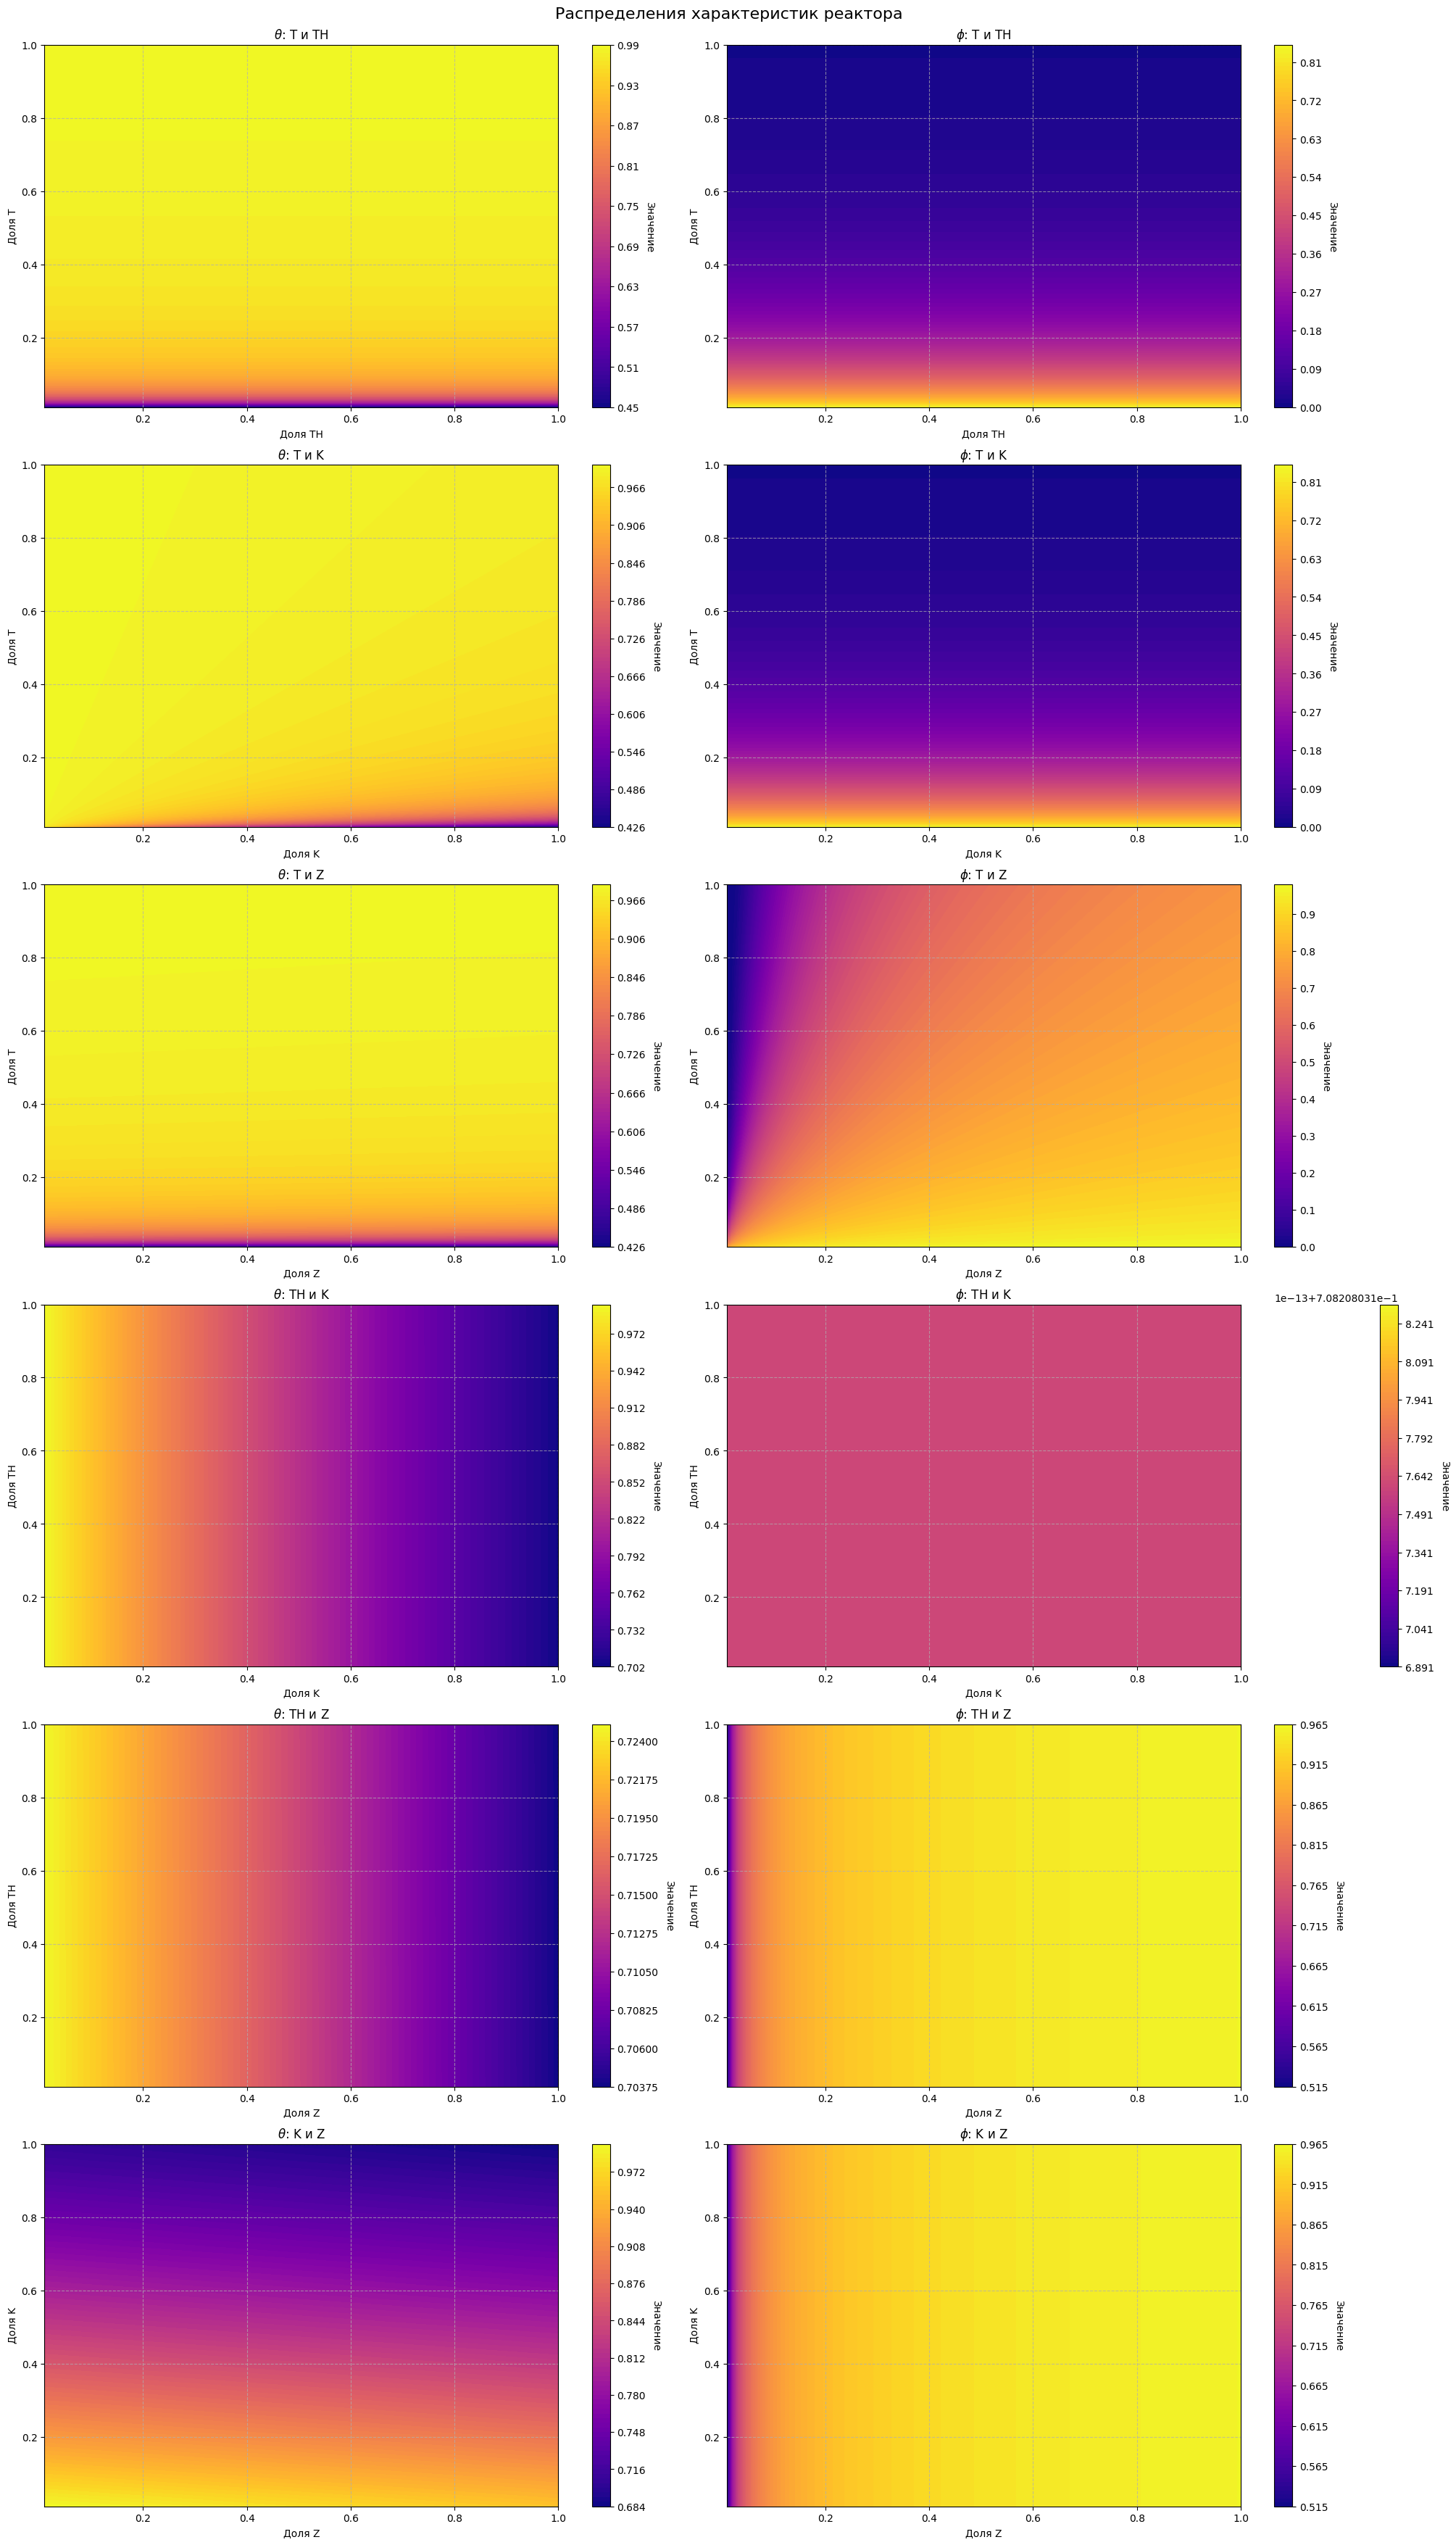

In [12]:
def change_params(name1, v1, name2, v2, reactor, mode):
    if name1 == 'TH':
        reactor.tn_props['eps'] = v1
    if name2 == 'TH':
        reactor.tn_props['eps'] = v2

    if name1 == 'K':
        reactor.k_props['eps'] = v1
    if name2 == 'K':
        reactor.k_props['eps'] = v2

    if name1 == 'Z':
        reactor.z_props['eps'] = v1
    if name2 == 'Z':
        reactor.z_props['eps'] = v2

    if name1 == 'T':
        reactor.t_eps = v1
    if name2 == 'T':
        reactor.t_eps = v2

    if mode == 0:
        return reactor.theta_calc()
    if mode == 1:
        return reactor.phi_calc()[0]
    return reactor.k_calc()

components = {'T': 'UO2', 'TH': 'D2O', 'K': 'Fe', 'Z': 'H2O'}
x = x_values[0]
reactor_type = 'RBMK'
reactor = HomoReactor(
    components.copy(),
    {
        'eps': PARAMS.reactors.loc['T', reactor_type],
        'N': PARAMS.Fuel.loc[components['T'], 'N'],
        'x': x
    },
    getOtherProps(components, reactor_type)
)

changes = ['T', 'TH', 'K', 'Z']

fig, axs = plt.subplots(6, 2, figsize=(20, 35), constrained_layout=True)
fig.suptitle("Распределения характеристик реактора", fontsize=16)

count = 0
for i in range(len(changes)):
    for j in range(i + 1, len(changes)):
        for mode in range(2):
            name1 = changes[i]
            name2 = changes[j]

            x_A = np.linspace(0.01, 1, 100)
            x_B = np.linspace(0.01, 1, 100)
            K = np.zeros([100, 100])

            for m, v1 in enumerate(x_A):
                for n, v2 in enumerate(x_B):
                    K[m, n] = change_params(name1, v1, name2, v2, reactor, mode)

            contour = axs[count, mode].contourf(x_A, x_B, K, levels=100, cmap='plasma')
            cbar = fig.colorbar(contour, ax=axs[count, mode])
            cbar.ax.set_ylabel('Значение', rotation=270, labelpad=15)

            title = ('$\\phi$' if mode else '$\\theta$') + f": {name1} и {name2}"


            axs[count, mode].set_title(title, fontsize=12)

            axs[count, mode].set_xlabel(f'Доля {name2}', fontsize=10)
            axs[count, mode].set_ylabel(f'Доля {name1}', fontsize=10)
            axs[count, mode].grid(True, linestyle='--', alpha=0.7)

            change_params(
                name1,
                share.loc[changes[i], "RBMK"],
                name2,
                share.loc[changes[j], "RBMK"],
                reactor,
                mode
            )

        count += 1

plt.show()


<>:48: SyntaxWarning: invalid escape sequence '\p'
<>:48: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-3604676572.py:48: SyntaxWarning: invalid escape sequence '\p'
  axs[i, mode].set_title(f'Коэффициент $\phi$ при изменении доли {name}')


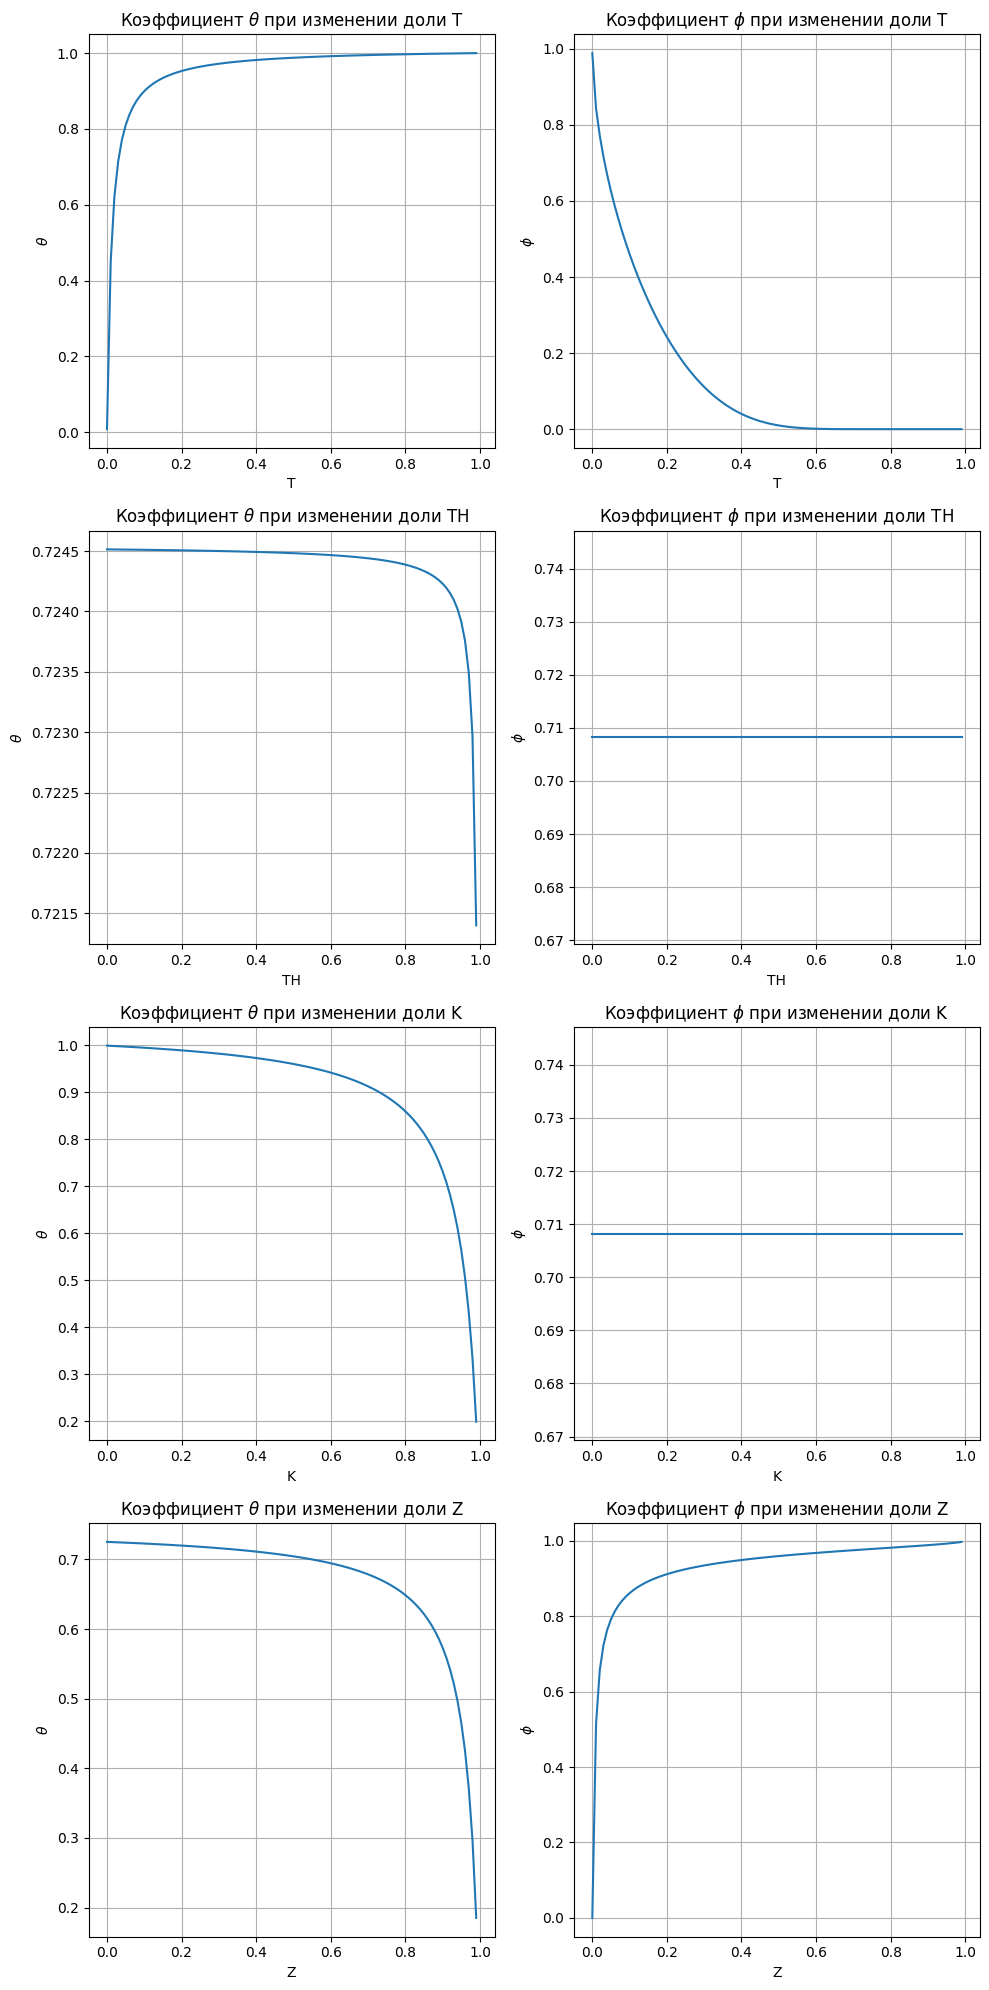

In [13]:
components = {'T': 'UO2', 'TH':'D2O', 'K': 'Fe', 'Z': 'H2O'}
x = x_values[0]
reactor_type = 'RBMK'
reactor = HomoReactor(components.copy(), {'eps': PARAMS.reactors.loc['T', reactorType], 'N': PARAMS.Fuel.loc[components['T'], 'N'], 'x': x}, getOtherProps(components, reactor_type))

fig, axs = plt.subplots(4, 2, figsize=(10, 20))

for i in range(len(changes)):
  for mode in range(2):
    name = changes[i]
    other_total = 1 - share.loc[name, "RBMK"]

    x = np.linspace(0.0001, 0.99, 100)
    K_values = []

    for v1 in x:
        remaining_fraction = (v1 - share.loc[name, "RBMK"])

        for name2 in changes:
            if name2 == 'T':
              if (name == name2):
                reactor.t_eps = v1
              else:
                reactor.t_eps = share.loc[name2, "RBMK"] - share.loc[name2, "RBMK"] / other_total * remaining_fraction
            if name2 == 'TH':
              if (name == name2):
                reactor.tn_props['eps'] = v1
              else:
                reactor.tn_props['eps'] = share.loc[name2, "RBMK"] - share.loc[name2, "RBMK"] / other_total * remaining_fraction
            if name2 == 'K':
              if (name == name2):
                reactor.k_props['eps'] = v1
              else:
                reactor.k_props['eps'] = share.loc[name2, "RBMK"] - share.loc[name2, "RBMK"] / other_total * remaining_fraction
            if name2 == 'Z':
              if (name == name2):
                reactor.z_props['eps'] = v1
              else:
                reactor.z_props['eps'] = share.loc[name2, "RBMK"] - share.loc[name2, "RBMK"] / other_total * remaining_fraction

        if (mode):
          K_values.append(reactor.phi_calc()[0])
        else:
          K_values.append(reactor.theta_calc())

    axs[i, mode].plot(x, K_values)
    if (mode):
      axs[i, mode].set_title(f'Коэффициент $\phi$ при изменении доли {name}')
      axs[i, mode].set_ylabel(r'$\phi$')
    else:
      axs[i, mode].set_title(fr'Коэффициент $\theta$ при изменении доли {name}')
      axs[i, mode].set_ylabel(r'$\theta$')
    axs[i, mode].set_xlabel(f'{name}')
    axs[i, mode].grid()
plt.tight_layout()


#Вывод:
Из этих графиков можно сделать вывод, что коэффициент $\phi$ при изменении доли Теплоносителя или доли конструкционных материалов не изменяется, а следовательно не зависит от них. В остальных случаях явно наблюдается сиьлная зафисимость коэффициентов от обьемных плотностей.

 $\phi$ уменьшается при увелиении доли теплоносителя и увеличивается при увеличении доли замедлителя.

$\theta$ растет с ростом доли теплоносителя и уменьшается во всех остальных случаях.

### 3.Исследования для среды, состоящей только из урана и замедлителя, доля топлива равна равной доле топлива в РБМК.

In [14]:
PARAMS.reactors['uranOnly'] = PARAMS.reactors['VVER']
PARAMS.reactors.loc['K', 'uranOnly'] = 0
PARAMS.reactors.loc['TH', 'uranOnly'] = 0
PARAMS.reactors.loc['Z', 'uranOnly'] = 1 - PARAMS.reactors.loc['T', 'uranOnly']


Комбинации


In [15]:
fuels = ['U', 'UO2']  # Топливо [T]
moderators = ['H2O', 'D2O', 'C']  # Замедлитель [З]

combinations = list(itertools.product(fuels, moderators))

for k in combinations:
    print(k)


('U', 'H2O')
('U', 'D2O')
('U', 'C')
('UO2', 'H2O')
('UO2', 'D2O')
('UO2', 'C')


### 3.1. Расчет коэффициента размножения


/tmp/ipython-input-642496044.py:28: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  axs.plot(
/tmp/ipython-input-642496044.py:28: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  axs.plot(
/tmp/ipython-input-642496044.py:28: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  axs.plot(
/tmp/ipython-input-642496044.py:28: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and

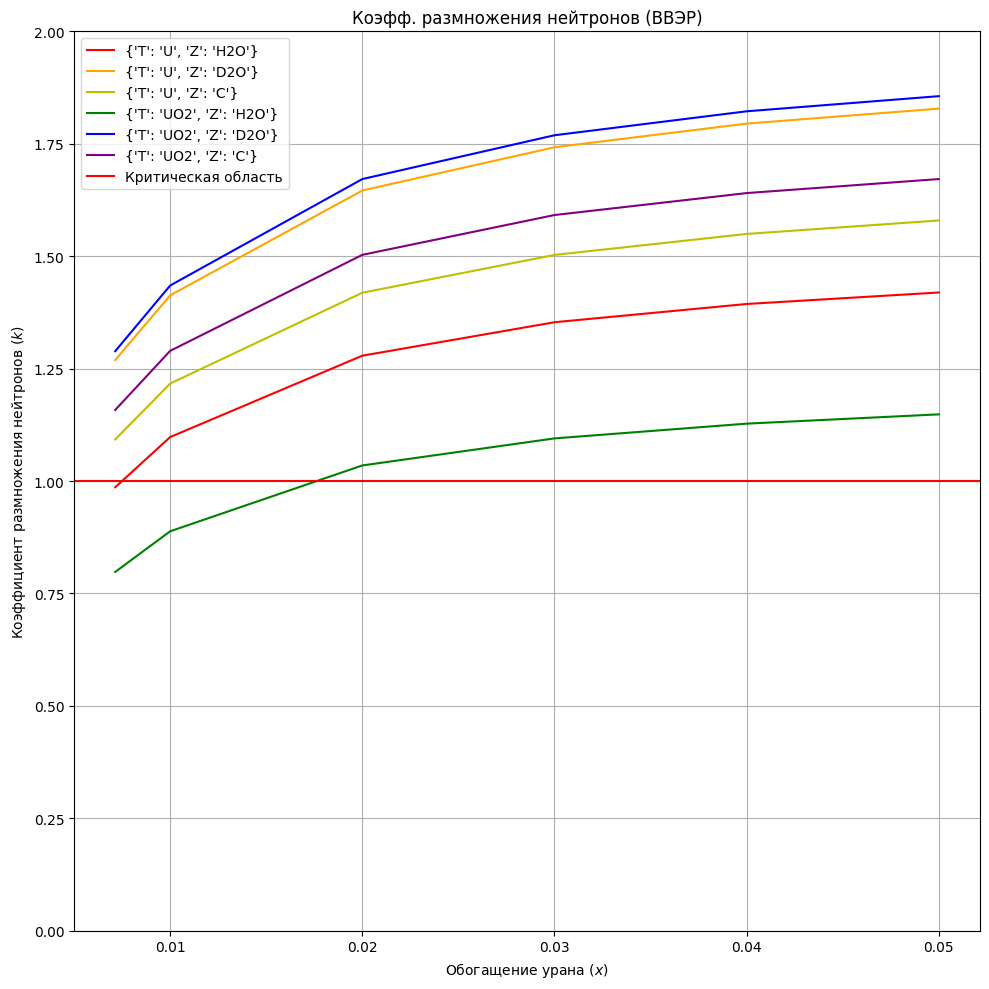

In [16]:
fig, axs = plt.subplots(figsize=(10, 10))

colors = ['r', 'orange', 'y', 'g', 'blue', 'purple']

color_index = 0

for var in combinations:
    reactorType = "uranOnly"
    components = {'T': var[0], 'Z': var[1], 'TH': 'Zr', 'K': 'Fe'}

    k_values = []
    reactor = HomoReactor(
        components=components.copy(),
        t_props=pd.Series(data=[x_vals[0], PARAMS.reactors.loc['T', reactorType], PARAMS.Fuel.loc[components['T'], 'N']],
                          index=['x', 'eps', 'N']),
        other_props=getOtherProps(components, reactorType)
    )

    for _x_ in x_values:
        reactor.set_x(_x_)
        k_value = reactor.k_calc()
        k_values.append(k_value)

    tmp = components.fromkeys(['T', 'Z'])
    tmp['T'] = components['T']
    tmp['Z'] = components['Z']

    axs.plot(
        x_values, k_values,
        color=colors[color_index % len(colors)],
        label=tmp
    )

    color_index += 1

axs.set_title('Коэфф. размножения нейтронов (ВВЭР)')

axs.axhline(y=1, color='r', label='Критическая область')

axs.set_xlabel('Обогащение урана ($x$)')
axs.set_ylabel('Коэффициент размножения нейтронов ($k$)')
axs.grid(True)
axs.legend()
axs.set_ylim(0, 2)

plt.tight_layout()

#Вывод:
Для среды, состоящей только из урана и замедлителя у реактора типа ВВЭР лучшей комбинацией компонент является ('UO2', 'H2O').

### 2. Зависимость сомножителей k от объемной доли компонент


<>:24: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-2085419962.py:24: SyntaxWarning: invalid escape sequence '\p'
  axs[mode].set_title(f'Коэффициент $\phi$ при изменении доли {name}')


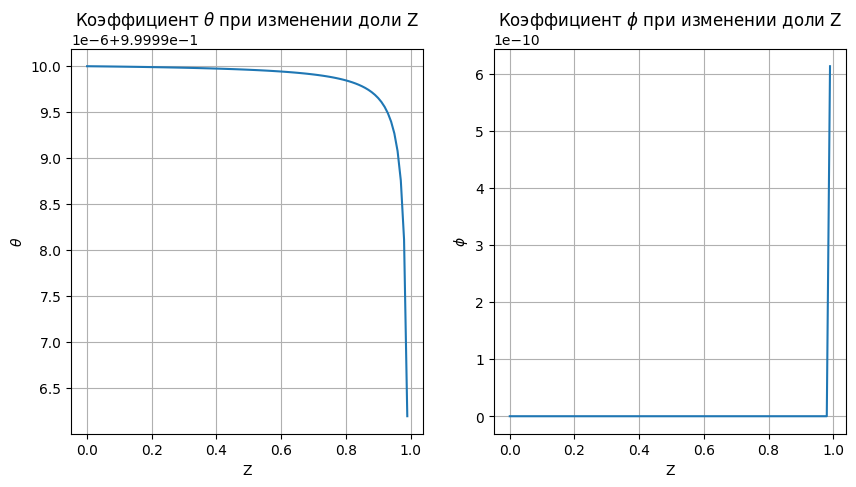

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for mode in range(2):
  name = 'Z'
  other_total = 1 - share.loc[name, "uranOnly"]

  x = np.linspace(0.0001, 0.99, 100)
  K_values = []

  for v1 in x:
      remaining_fraction = (v1 - share.loc[name, "uranOnly"])


      reactor.t_eps = share.loc[name2, "uranOnly"] - share.loc[name2, "uranOnly"] / other_total * remaining_fraction
      reactor.z_props['eps'] = v1

      if (mode):
        K_values.append(reactor.phi_calc()[0])
      else:
        K_values.append(reactor.theta_calc())

  axs[mode].plot(x, K_values)
  if (mode):
    axs[mode].set_title(f'Коэффициент $\phi$ при изменении доли {name}')
    axs[mode].set_ylabel(r'$\phi$')
  else:
    axs[mode].set_title(fr'Коэффициент $\theta$ при изменении доли {name}')
    axs[mode].set_ylabel(r'$\theta$')
  axs[mode].set_xlabel(f'{name}')
  axs[mode].grid()

#Вывод:
Сильно изменилась завизимость $\phi$ от замедлителя, теперь она растет только при близких к 1 значениях доли замедлителя.

Тем временм график зависимости $\theta$ от доли замедлителя схож с предыдущим.

##Заключение
В ходе исследования был проведен расчет коэффициента размножения нейтронов в гомогенном реакторе с использованием формулы четырех сомножителей. Были определены значения коэффициента для разных типов реакторов (РБМК и ВВЭР), а также для различных сочетаний компонентов, таких как топливо, теплоноситель, замедлитель и конструкционные материалы.

Результаты показали, что для нормальной работы реактора коэффициент размножения должен быть близким к единице, что свидетельствует о критическом состоянии реактора, когда количество нейтронов, создаваемых в результате деления, уравновешивает количество поглощаемых нейтронов. Для некоторых комбинаций компонентов и уровней обогащения урана коэффициент размножения оказался близким к критическому значению, что подтвердило правильность выбранных моделей и методов расчета.


